In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
# torch.manual_seed
import pandas as pd

In [131]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        # * Done
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        self.n_phases = 16
        self.alpha_f = 0.005
        self.alpha_s = 0.08
        self.h_f = 5
        self.h_s = 6
        self.T_hot = 4
        self.T_0 = 1
        self.U_f = 1 

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 8],  # Time dimension
                                            [0, 1]])  # Space dimension
        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        

        # FF Dense NN to approximate the T_f we wish to infer
        self.approximate_coefficient = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                                 n_hidden_layers=4,
                                                 neurons=20,
                                                 regularization_param=0.,
                                                 regularization_exp=2.,
                                                 retrain_seed=42)

                                    
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int, self.training_set_meas = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        # * Done
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]
    

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary

    def get_fluid_velocity(self, inputs):
        # * Done
        U_f = torch.full(inputs.shape, 999)
    
        for i, t in enumerate(inputs):
            # Charging Phase
            if (t <=1) or (t > 4 and t<=5): U_f[i] = 1
            # Idle Phase
            elif (t > 1 and t <= 2) or (t > 3 and t <= 4) or (t > 5 and t <= 6) or (t > 7 and t<= 8): U_f[i] = 0
            # Discharging Phase
            elif (t > 2 and t <= 3) or (t > 6 and t <= 7): U_f[i] = -1
        return U_f
    

    def add_temporal_boundary_points(self):
        # * Correct
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = torch.full(input_tb[:, 0].shape, self.T_0).reshape(-1,1)
        return input_tb, output_tb


    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        # * Correct

        def time_shift_array(array_x0, array_xL, delta_t):
            array_x0_cloned = torch.clone(array_x0)
            array_xL_cloned = torch.clone(array_xL) 

            # Shift the time for soboleng time components to be in [1,2]
            array_x0_cloned[:, 0] = array_x0_cloned[:, 0] + delta_t
            array_xL_cloned[:, 0] = array_xL_cloned[:, 0] + delta_t
            array_merged=  torch.cat((array_x0_cloned, array_xL_cloned), dim=0) # Input data for the charging phase with t in [0,1]

            return array_merged

        # Obtain the input spatuial boundary points
        ############################################################
        # Get x-coordinates of the extrema of the domain
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.soboleng.draw(self.n_sb)

        # Scale the Soboleng points from [0,8]
        scaled_input_sb = self.domain_extrema[0,1] * input_sb[:, 1]

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        ############################################################

        '''Implementation of one Cycle (charging -> idle -> discharging -> idle)'''

        # * Charging Phase
        input_sb_charge = time_shift_array(input_sb_0, input_sb_L, 0)
        # print("Input spatial charge shape: ", input_sb_charge)
        charge_output_0 = torch.full(input_sb_0[:, 1].shape, self.T_hot).reshape(-1,1)
        charge_output_L = torch.full(input_sb_L[:, 1].shape, 0).reshape(-1,1)
        charge_ouput = torch.cat((charge_output_0, charge_output_L), dim=0)
    
        # * Discharging Phase

        input_sb_discharge = time_shift_array(input_sb_0, input_sb_L, 2)
        discharge_output_0 = torch.full(input_sb_0[:, 1].shape, 0).reshape(-1,1)
        discharge_output_L = torch.full(input_sb_L[:, 1].shape, self.T_0).reshape(-1,1) #T_0 is the same as T_cold
        discharge_output = torch.cat((discharge_output_0, discharge_output_L), dim=0)


        # * Idle Phase 1
        input_sb_idle1 =  time_shift_array(input_sb_0, input_sb_L, 1)
        idle_output_0 = torch.full(input_sb_0[:, 1].shape, 0).reshape(-1,1)
        idle_output_L = torch.full(input_sb_L[:, 1].shape, 0).reshape(-1,1)
        idle_output_1 = torch.cat((idle_output_0, idle_output_L), dim=0)


         # * Idle Phase 2
        input_sb_idle2 =  time_shift_array(input_sb_0, input_sb_L, 3)
        idle_output_2 = torch.cat((idle_output_0, idle_output_L), dim=0)

        cat_input_1 =  torch.cat([input_sb_charge, input_sb_idle1, input_sb_discharge, input_sb_idle2], 0)
        cat_output_1 = torch.cat([charge_ouput, idle_output_1, discharge_output, idle_output_2], 0)

        cat_input_2 =  torch.cat([input_sb_charge, input_sb_idle1, input_sb_discharge, input_sb_idle2], 0)
        cat_input_2[:, 0] = cat_input_2[:, 0] + 4 # Shift the time components to be in the second cycle
        cat_output_2 = torch.cat([charge_ouput, idle_output_1, discharge_output, idle_output_2], 0)
        return torch.cat([cat_input_1.requires_grad_(True), cat_input_2.requires_grad_(True)], 0), torch.cat([cat_output_1, cat_output_2], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        # * Correct
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int
    
    def get_measurement_data(self):
        # * Correct
        df_meas = pd.read_csv('Task2/DataSolution.txt')
        tensor_meas = torch.tensor(df_meas.values , dtype=torch.float)
        input_meas = tensor_meas[:, :2]
        output_meas = tensor_meas[:, 2:]
        return input_meas, output_meas
        

    # Function returning the training sets S_sb, S_tb, S_int and S_data as dataloader
    def assemble_datasets(self):
        # * Correct
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int
        input_meas, output_meas = self.get_measurement_data()      # S_meas

        training_set_data = DataLoader(torch.utils.data.TensorDataset(input_meas, output_meas), batch_size= output_meas.shape[0], shuffle=False)
        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=self.n_phases*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int, training_set_data

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    # Takes as input the temporal boundary points and returns the prediction of the neural network at the temporal boundary points
    def apply_initial_condition(self, input_tb):
        # * Correct
        u_pred_tb = self.approximate_solution(input_tb)
        #print(u_pred_tb)
        return u_pred_tb

    def get_phase_arr(self, input_arr, cycle, phase):
            #* Correct

            #Phase 1 == Charging 
            #Phase 2 == Idle
            #Phase 3 == Discharging
            #Phase 4 == Idle

            points_per_phase = 2*int(input_arr.shape[0]/(self.n_phases)) # First part is x0 then xL
            if cycle == 1:
                if phase == 1:
                    return input_arr[:points_per_phase, :]
                elif phase == 2:
                    return input_arr[points_per_phase:2*points_per_phase, :]
                elif phase == 3:
                    return input_arr[2*points_per_phase:3*points_per_phase, :]
                elif phase == 4:
                    return input_arr[3*points_per_phase:4*points_per_phase, :]
            elif cycle == 2:
                if phase == 1:
                    return input_arr[4*points_per_phase: 5*points_per_phase, :]
                elif phase == 2:
                    return input_arr[5*points_per_phase: 6*points_per_phase, :]
                elif phase == 3:
                    return input_arr[6*points_per_phase: 7*points_per_phase, :]
                elif phase == 4:   
                    return input_arr[7*points_per_phase: , :]


    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    # Takes as input the spatial boundary points and returns the prediction of the neural network at the temporal boundary points
    
    def apply_boundary_conditions(self, input_sb):
        #* Correct
        ################################################################################################

        '''
        ###########################
        Cycle 1 (Input Points)
        ###########################
        '''

        input_sb_charging_0 = self.get_phase_arr(input_sb, 1, 1)[:int(input_sb.shape[0]/16)]
        input_sb_charging_L = self.get_phase_arr(input_sb, 1, 1)[int(input_sb.shape[0]/16):]


        input_sb_idle_0_1 = self.get_phase_arr(input_sb, 1, 2)[:int(input_sb.shape[0]/16)]
        input_sb_idle_L_1 = self.get_phase_arr(input_sb, 1, 2)[int(input_sb.shape[0]/16):]

        input_sb_discharging_0 = self.get_phase_arr(input_sb, 1, 3)[:int(input_sb.shape[0]/16)]
        input_sb_discharging_L = self.get_phase_arr(input_sb, 1, 3)[int(input_sb.shape[0]/16):]

        input_sb_idle_0_2 = self.get_phase_arr(input_sb, 1, 4)[:int(input_sb.shape[0]/16)]
        input_sb_idle_L_2 = self.get_phase_arr(input_sb, 1, 4)[int(input_sb.shape[0]/16):]


        '''
        ###########################
        Cycle 2 (Input Points)
        ###########################
        '''

        input_sb_charging_0_2 = self.get_phase_arr(input_sb, 2, 1)[:int(input_sb.shape[0]/16)]
        input_sb_charging_L_2 = self.get_phase_arr(input_sb, 2, 1)[int(input_sb.shape[0]/16):]


        input_sb_idle_0_3 = self.get_phase_arr(input_sb, 2, 2)[:int(input_sb.shape[0]/16)]
        input_sb_idle_L_3 = self.get_phase_arr(input_sb, 2, 2)[int(input_sb.shape[0]/16):]
 

        input_sb_discharging_0_2 = self.get_phase_arr(input_sb, 2, 3)[:int(input_sb.shape[0]/16)]
        input_sb_discharging_L_2 = self.get_phase_arr(input_sb, 2, 3)[int(input_sb.shape[0]/16):]

        input_sb_idle_0_4 = self.get_phase_arr(input_sb, 2, 4)[:int(input_sb.shape[0]/16)]
        input_sb_idle_L_4 = self.get_phase_arr(input_sb, 2, 4)[int(input_sb.shape[0]/16):]

        ################################################################################################


        ''' Get boundary condition for Charging state '''
        # Cycle 1
        Tf_sb_0_charging_1 = self.approximate_solution(input_sb_charging_0).reshape(-1,1)
        Tf_sb_L_charging_1 = self.approximate_solution(input_sb_charging_L).reshape(-1,1)
        grad_Tf_sb_L_charging_1 = torch.autograd.grad(Tf_sb_L_charging_1.sum(), input_sb_charging_L, create_graph=True)[0][:, 1].reshape(-1,1)

        # Cycle 2
        Tf_sb_0_charging_2 = self.approximate_solution(input_sb_charging_0_2).reshape(-1,1)
        Tf_sb_L_charging_2 = self.approximate_solution(input_sb_charging_L_2).reshape(-1,1)
        grad_Tf_sb_L_charging_2 = torch.autograd.grad(Tf_sb_L_charging_2.sum(), input_sb_charging_L_2, create_graph=True)[0][:, 1].reshape(-1,1)

        ''' Get boundary condition for Discharging state '''
        # Cycle 1
        Tf_sb_0_discharging_1 = self.approximate_solution(input_sb_discharging_0).reshape(-1,1)
        grad_Tf_sb_0_discharging_1 = torch.autograd.grad(Tf_sb_0_discharging_1.sum(), input_sb_discharging_0, create_graph=True)[0][:, 1].reshape(-1,1)
        Tf_sb_L_discharging_1 = self.approximate_solution(input_sb_discharging_L).reshape(-1,1)
        # grad_Tf_sb_L_discharging_1 = torch.autograd.grad(Tf_sb_L_discharging_1.sum(), input_sb_discharging_L, create_graph=True)[0][:, 1].reshape(-1,1)

        # Cycle 2
        Tf_sb_0_discharging_2 = self.approximate_solution(input_sb_discharging_0_2).reshape(-1,1)
        grad_Tf_sb_0_discharging_2 = torch.autograd.grad(Tf_sb_0_discharging_2.sum(), input_sb_discharging_0_2, create_graph=True)[0][:, 1].reshape(-1,1)
        Tf_sb_L_discharging_2 = self.approximate_solution(input_sb_discharging_L_2).reshape(-1,1)
        # grad_Tf_sb_L_discharging_2 = torch.autograd.grad(Tf_sb_L_discharging_2.sum(), input_sb_discharging_L_2, create_graph=True)[0][:, 1].reshape(-1,1)


        ''' Get boundary condition for Idle state '''

        # We take the second column in each case since we only have derivatives in x

        # Cycle 1
        # First Idle in Cycle 1
        Tf_sb_0_idle_1 = self.approximate_solution(input_sb_idle_0_1).reshape(-1,1)
        Tf_sb_L_idle_1 = self.approximate_solution(input_sb_idle_L_1).reshape(-1,1)
        grad_Tf_sb_0_idle_1 = torch.autograd.grad(Tf_sb_0_idle_1.sum(), input_sb_idle_0_1, create_graph=True)[0][:, 1].reshape(-1,1) # *
        grad_Tf_sb_L_idle_1 = torch.autograd.grad(Tf_sb_L_idle_1.sum(), input_sb_idle_L_1, create_graph=True)[0][:, 1].reshape(-1,1) # *
        
        # Second Idle in Cycle 1
        Tf_sb_0_idle_2 = self.approximate_solution(input_sb_idle_0_2).reshape(-1,1)
        Tf_sb_L_idle_2 = self.approximate_solution(input_sb_idle_L_2).reshape(-1,1)
        grad_Tf_sb_0_idle_2 = torch.autograd.grad(Tf_sb_0_idle_2.sum(), input_sb_idle_0_2, create_graph=True)[0][:, 1].reshape(-1,1) # *
        grad_Tf_sb_L_idle_2 = torch.autograd.grad(Tf_sb_L_idle_2.sum(), input_sb_idle_L_2, create_graph=True)[0][:, 1].reshape(-1,1) # *

        # Cycle 2
        # First Idle in Cycle 2
        Tf_sb_0_idle_3 = self.approximate_solution(input_sb_idle_0_3).reshape(-1,1)
        Tf_sb_L_idle_3 = self.approximate_solution(input_sb_idle_L_3).reshape(-1,1)
        grad_Tf_sb_0_idle_3 = torch.autograd.grad(Tf_sb_0_idle_3.sum(), input_sb_idle_0_3, create_graph=True)[0][:, 1].reshape(-1,1) # *
        grad_Tf_sb_L_idle_3 = torch.autograd.grad(Tf_sb_L_idle_3.sum(), input_sb_idle_L_3, create_graph=True)[0][:, 1].reshape(-1,1) # *
        
        # Second Idle in Cycle 2
        Tf_sb_0_idle_4 = self.approximate_solution(input_sb_idle_0_4).reshape(-1,1)
        Tf_sb_L_idle_4 = self.approximate_solution(input_sb_idle_L_4).reshape(-1,1)
        grad_Tf_sb_0_idle_4 = torch.autograd.grad(Tf_sb_0_idle_4.sum(), input_sb_idle_0_4, create_graph=True)[0][:, 1].reshape(-1,1) # *
        grad_Tf_sb_L_idle_4 = torch.autograd.grad(Tf_sb_L_idle_4.sum(), input_sb_idle_L_4, create_graph=True)[0][:, 1].reshape(-1,1) # *

        cat_tensor = torch.cat([
            # Cycle 1
            Tf_sb_0_charging_1, grad_Tf_sb_L_charging_1, grad_Tf_sb_0_idle_1, grad_Tf_sb_L_idle_1, grad_Tf_sb_0_discharging_1, Tf_sb_L_discharging_1,  grad_Tf_sb_0_idle_2, grad_Tf_sb_L_idle_2,
            # Cycle  2
            Tf_sb_0_charging_2, grad_Tf_sb_L_charging_2, grad_Tf_sb_0_idle_3, grad_Tf_sb_L_idle_3 , grad_Tf_sb_0_discharging_2, Tf_sb_L_discharging_2, grad_Tf_sb_0_idle_4, grad_Tf_sb_L_idle_4
        ], 0)

        return cat_tensor



    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        # * Correct
        input_int.requires_grad = True
        # Obtain the prediction from the neural network
        Tf = self.approximate_solution(input_int).reshape(-1,)
        Ts = self.approximate_coefficient(input_int).reshape(-1,)
        
        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi

        grad_tf = torch.autograd.grad(Tf.sum(), input_int, create_graph=True)[0]
        grad_tf_t = grad_tf[:,0]
        grad_tf_x = grad_tf[:,1]
        
        grad_tf_xx = torch.autograd.grad(grad_tf_x.sum(), input_int, create_graph=True)[0][:,1]
        
        U_f = self.get_fluid_velocity(input_int[:, 0])

        residual = (grad_tf_t + U_f*grad_tf_x) - (self.alpha_f*grad_tf_xx - self.h_f*(Tf - Ts))
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, u_train_int, inp_train_meas, u_train_meas, verbose=True):

        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)
        u_pred_meas = self.approximate_solution(inp_train_meas) 

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        assert (u_pred_meas.shape[1] == u_train_meas.shape[1])

        # Interior point loss
        r_int = self.compute_pde_residual(inp_train_int)

        # Initial Condition loss
        r_tb = u_train_tb - u_pred_tb

        # Measurement loss
        r_meas = u_train_meas - u_pred_meas

        # Spatial Boundary loss
        r_sb = u_train_sb - u_pred_sb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2) 
        loss_meas = torch.mean(abs(r_meas) ** 2)

        if verbose: print("loss sb: ", round(loss_sb.item(), 4), "| loss tb: ", round(torch.log10(loss_tb).item(), 4), "| loss int: ", round(torch.log10(loss_int).item(), 4), "| loss meas: ", round(torch.log10(loss_meas).item(), 4)) 

        loss_u = loss_sb + loss_tb + loss_meas

        loss = torch.log10(self.lambda_u * 1*loss_u + 1*loss_int)
        #if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))
        if verbose: print("Total loss: ", round(loss.item(), 4), "| Boundary loss: ", round(torch.log10(loss_tb).item(), 4), "| Measure Loss: ", round(torch.log10(loss_meas).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4)) 
        return loss



    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int), (inp_train_data, u_train_data)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int, self.training_set_meas)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, u_train_int, inp_train_data, u_train_data, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################

    def plotting(self, vmax_=None):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output_tf = self.approximate_solution(inputs).reshape(-1, )
        output_ts = self.approximate_coefficient(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        if vmax_ is None: im1 = axs[0].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=output_tf.detach(), cmap="jet")
        else: im1 = axs[0].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=output_tf.detach(), cmap="jet", vmax=vmax_)
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("x")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        if vmax_ is None: im2 = axs[1].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=output_ts.detach(), cmap="jet")
        else: im2 = axs[1].scatter(inputs[:, 0].detach(), inputs[:, 1].detach(), c=output_ts.detach(), cmap="jet", vmax=vmax_)
        axs[1].set_xlabel("t")
        axs[1].set_ylabel("x")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title(r"Approximate Solution $T_f$")
        axs[1].set_title(r"Approximate Solution $T_s$")

        plt.show()


In [133]:
n_int =  2048
n_sb = 64
n_tb = 128

pinn = Pinns(n_int, n_sb, n_tb)

In [125]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution.parameters()) + list(pinn.approximate_coefficient.parameters()),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

################################  0  ################################
loss sb:  2.0829 | loss tb:  -0.1632 | loss int:  -0.3062 | loss meas:  0.2926
Total loss:  1.6795 | Boundary loss:  -0.1632 | Measure Loss:  0.2926 | Function Loss:  -0.3062
loss sb:  1.9248 | loss tb:  -0.3565 | loss int:  -0.0077 | loss meas:  0.2284
Total loss:  1.6186 | Boundary loss:  -0.3565 | Measure Loss:  0.2284 | Function Loss:  -0.0077
loss sb:  1.2977 | loss tb:  -1.1164 | loss int:  0.752 | loss meas:  -0.0868
Total loss:  1.4406 | Boundary loss:  -1.1164 | Measure Loss:  -0.0868 | Function Loss:  0.752
loss sb:  1.2341 | loss tb:  -1.0777 | loss int:  0.6437 | loss meas:  -0.1262
Total loss:  1.399 | Boundary loss:  -1.0777 | Measure Loss:  -0.1262 | Function Loss:  0.6437
loss sb:  0.8697 | loss tb:  -0.7327 | loss int:  -0.1386 | loss meas:  -0.3163
Total loss:  1.2069 | Boundary loss:  -0.7327 | Measure Loss:  -0.3163 | Function Loss:  -0.1386
loss sb:  0.7334 | loss tb:  -1.5657 | loss int:  -0.234

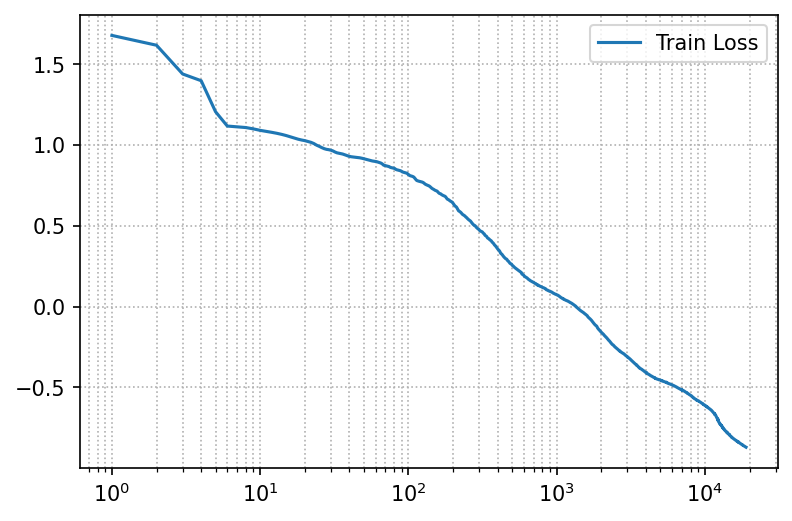

In [126]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

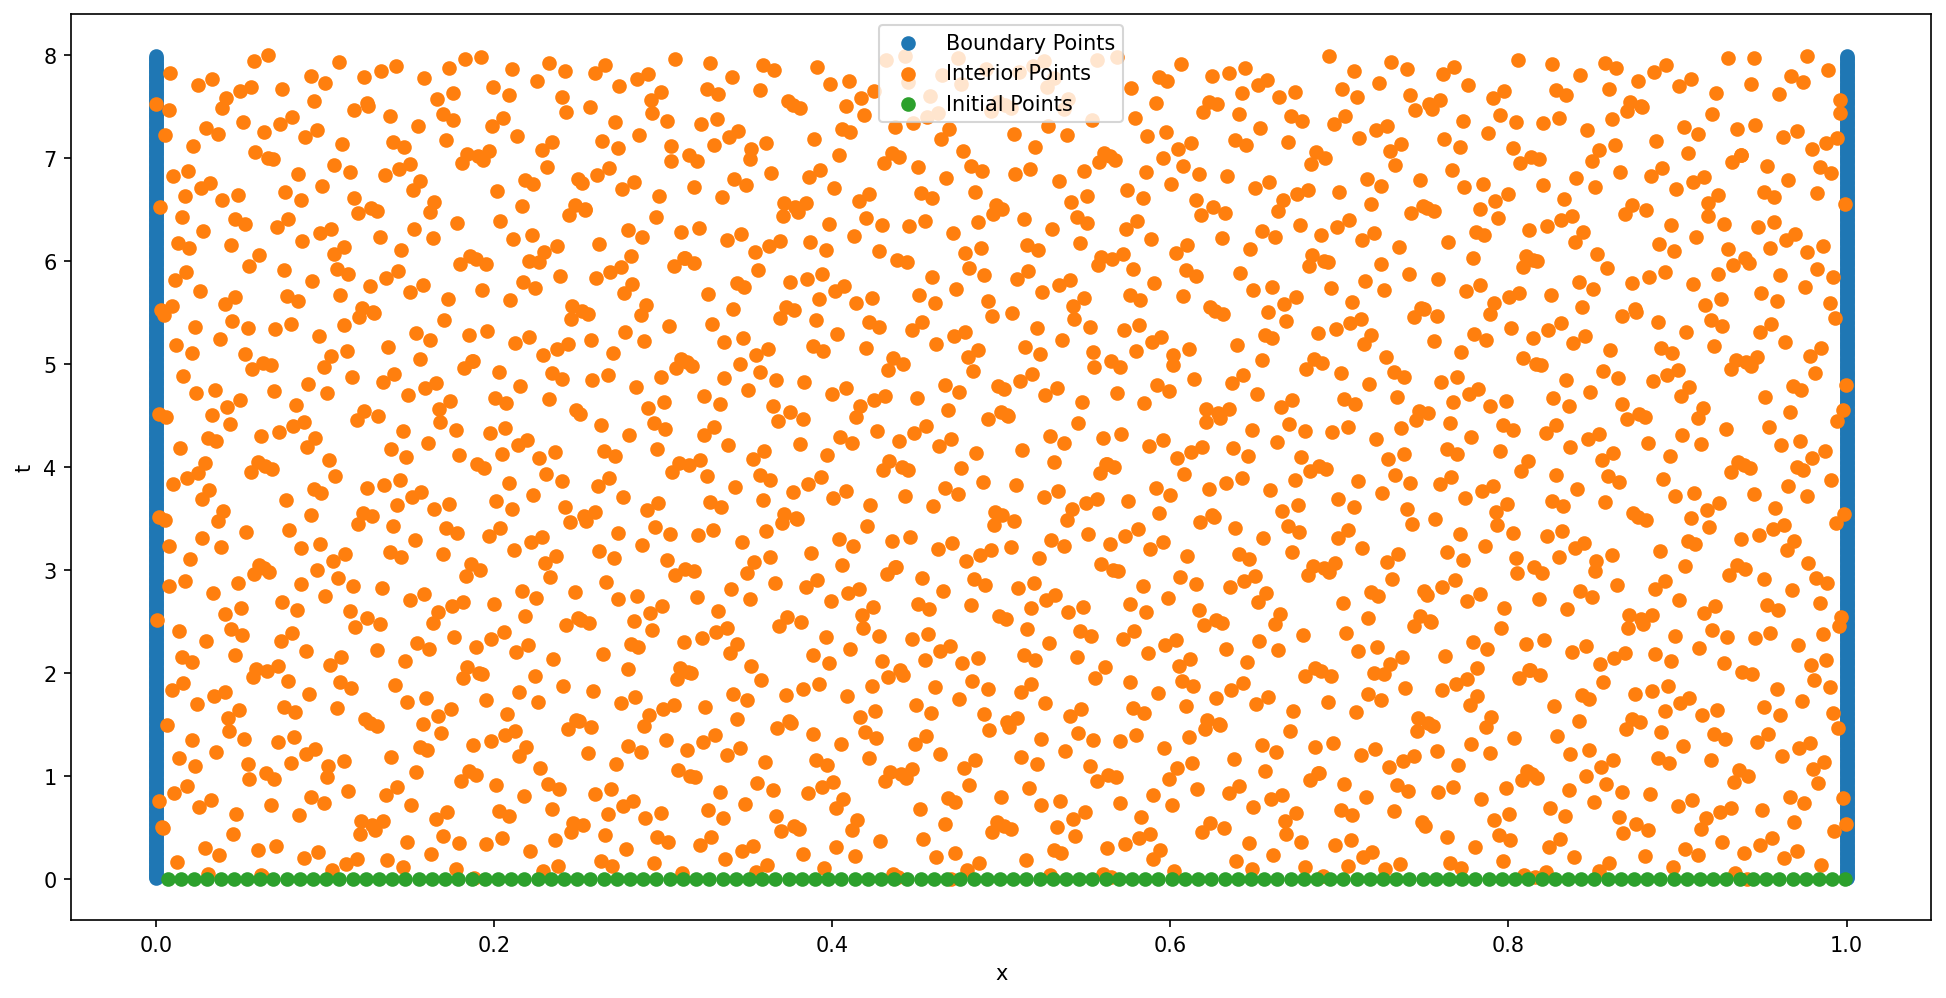

In [121]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

### Plot Exact Values

In [91]:
def get_measurement_data():
        df_meas = pd.read_csv('Task2/DataSolution.txt')
        tensor_meas = torch.tensor(df_meas.values , dtype=torch.float)
        input_meas = tensor_meas[:, :2]
        output_meas = tensor_meas[:, 2:]
        return input_meas, output_meas

#### Compare $T_s$

----------------------------------------------------
Parametes of the error for the Measured Data
----------------------------------------------------
L2 Relative Error Norm:  4.8062639236450195 %
mean error:			 0.7132057547569275
std error:			 0.9419404864311218


Text(0.5, 1.0, 'Approximate Values $T_s$')

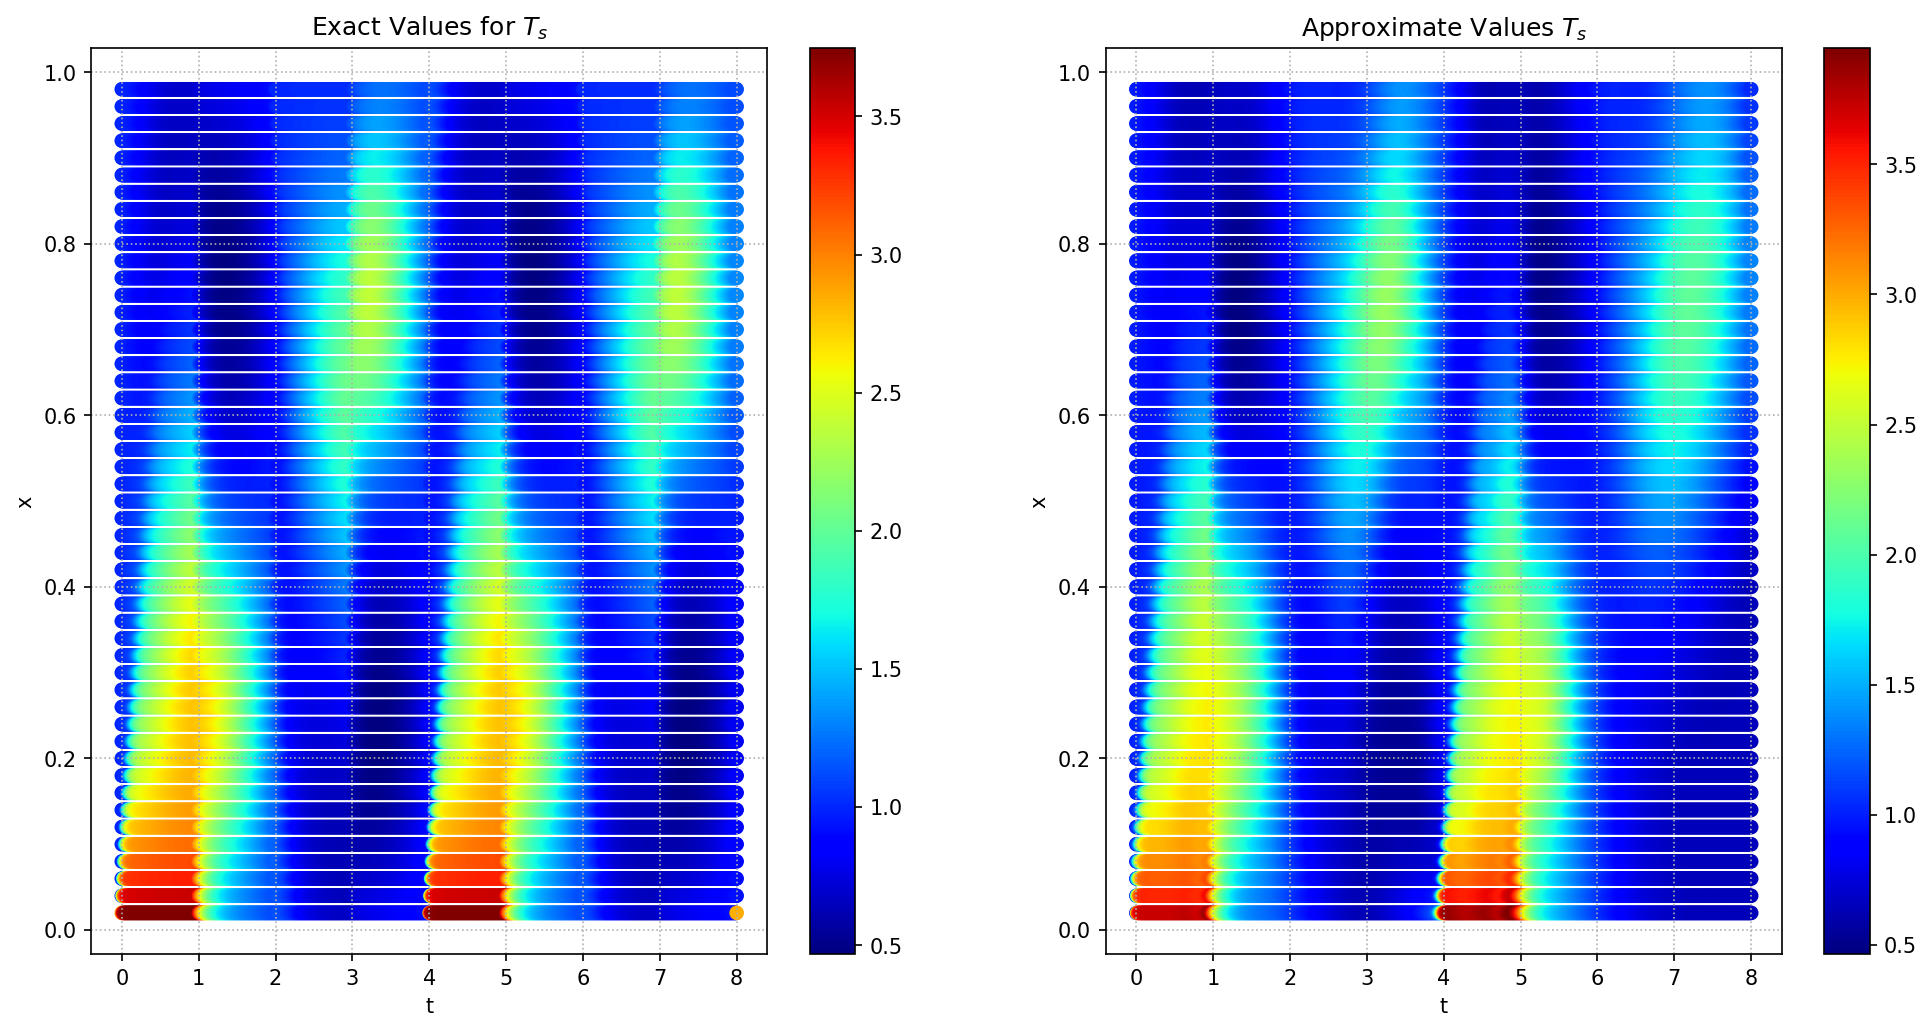

In [127]:
input_meas, exact_meas = get_measurement_data()

# Plot the predictions vs the exact solutions
fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(input_meas[:, 0].detach(), input_meas[:, 1].detach(), c=exact_meas.detach(), cmap='jet')
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
axs[0].set_title(r"Exact Values for $T_f$")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")


prediction_meas = pinn.approximate_solution(input_meas).reshape(-1, )

print('----------------------------------------------------')
print('Parametes of the error for the Measured Data')
print('----------------------------------------------------')
err = (torch.mean((exact_meas.flatten() - prediction_meas.flatten()) ** 2) / torch.mean(exact_meas ** 2)) ** 0.5 * 100
print("L2 Relative Error Norm: ", err.item(), "%")
print('mean error:\t\t\t', torch.mean(torch.abs( (exact_meas-prediction_meas)) ).item())
print('std error:\t\t\t', torch.std( (exact_meas-prediction_meas) ).item())

im2 = axs[1].scatter(input_meas[:, 0].detach(), input_meas[:, 1].detach(), c=prediction_meas.detach(), cmap="jet")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")

axs[1].set_title(r"Approximate Values $T_f$")

##### Save hyperparameters

In [128]:
torch.save(pinn.approximate_solution.state_dict(), 'approximate_solution_parameters_task2.pth')
torch.save(pinn.approximate_coefficient.state_dict(), 'approximate_coefficient_parameters_task2.pth')

In [134]:
pinn.approximate_solution.load_state_dict(torch.load("approximate_solution_parameters_task2.pth"))
pinn.approximate_coefficient.load_state_dict(torch.load("approximate_coefficient_parameters_task2.pth"))

<All keys matched successfully>

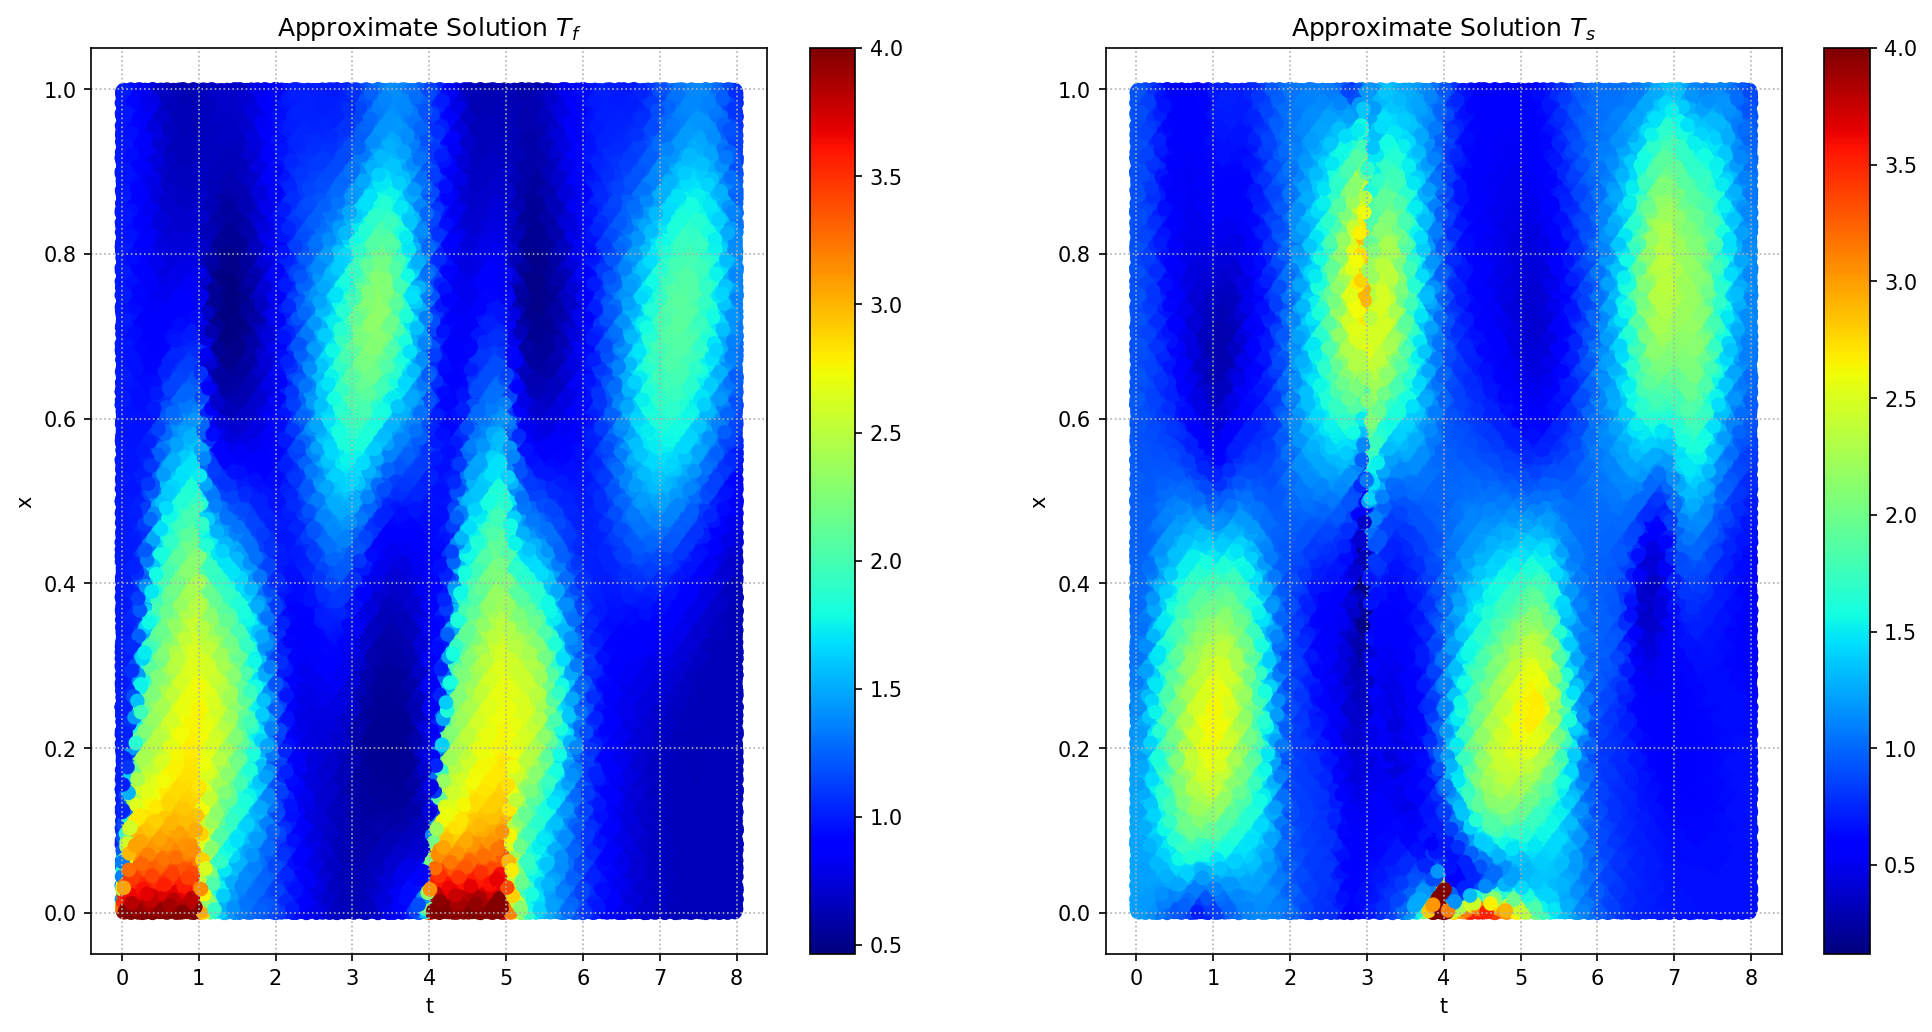

In [137]:
pinn.plotting(vmax_= 4.0)

#### Save predictions

In [142]:
import os
import pandas as pd

path = "Task2/SubExample.txt"
test_data = pd.read_csv(path)
test_data.drop(columns = ["ts"], inplace=  True)
test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32)


t     x
0      0.000000  0.02
1      0.010013  0.02
2      0.020025  0.02
3      0.030038  0.02
4      0.040050  0.02
...         ...   ...
39195  7.959950  0.98
39196  7.969963  0.98
39197  7.979975  0.98
39198  7.989988  0.98
39199  8.000000  0.98

[39200 rows x 2 columns]

In [144]:
solution_Ts = pinn.approximate_coefficient(test_data_tensor)

tensor([[1.2311],
        [1.2256],
        [1.2207],
        ...,
        [0.9064],
        [0.8993],
        [0.8925]], grad_fn=<AddmmBackward0>)


In [147]:
save_path_pred = "Fabian_Jaeger_17-740-325"
try:
    os.makedirs(save_path_pred)
except:
    print("Path already exists")

test_pred = test_data.copy()
test_pred['ts'] = solution_Ts.detach()
display(test_pred)

test_pred.to_csv("{}/pred2.txt".format(save_path_pred), header=True, index=None, sep=',', mode='w')

Path already exists


t     x        ts
0      0.000000  0.02  1.231053
1      0.010013  0.02  1.225555
2      0.020025  0.02  1.220699
3      0.030038  0.02  1.216457
4      0.040050  0.02  1.212791
...         ...   ...       ...
39195  7.959950  0.98  0.920960
39196  7.969963  0.98  0.913570
39197  7.979975  0.98  0.906362
39198  7.989988  0.98  0.899342
39199  8.000000  0.98  0.892511

[39200 rows x 3 columns]

#### Verify prediction array

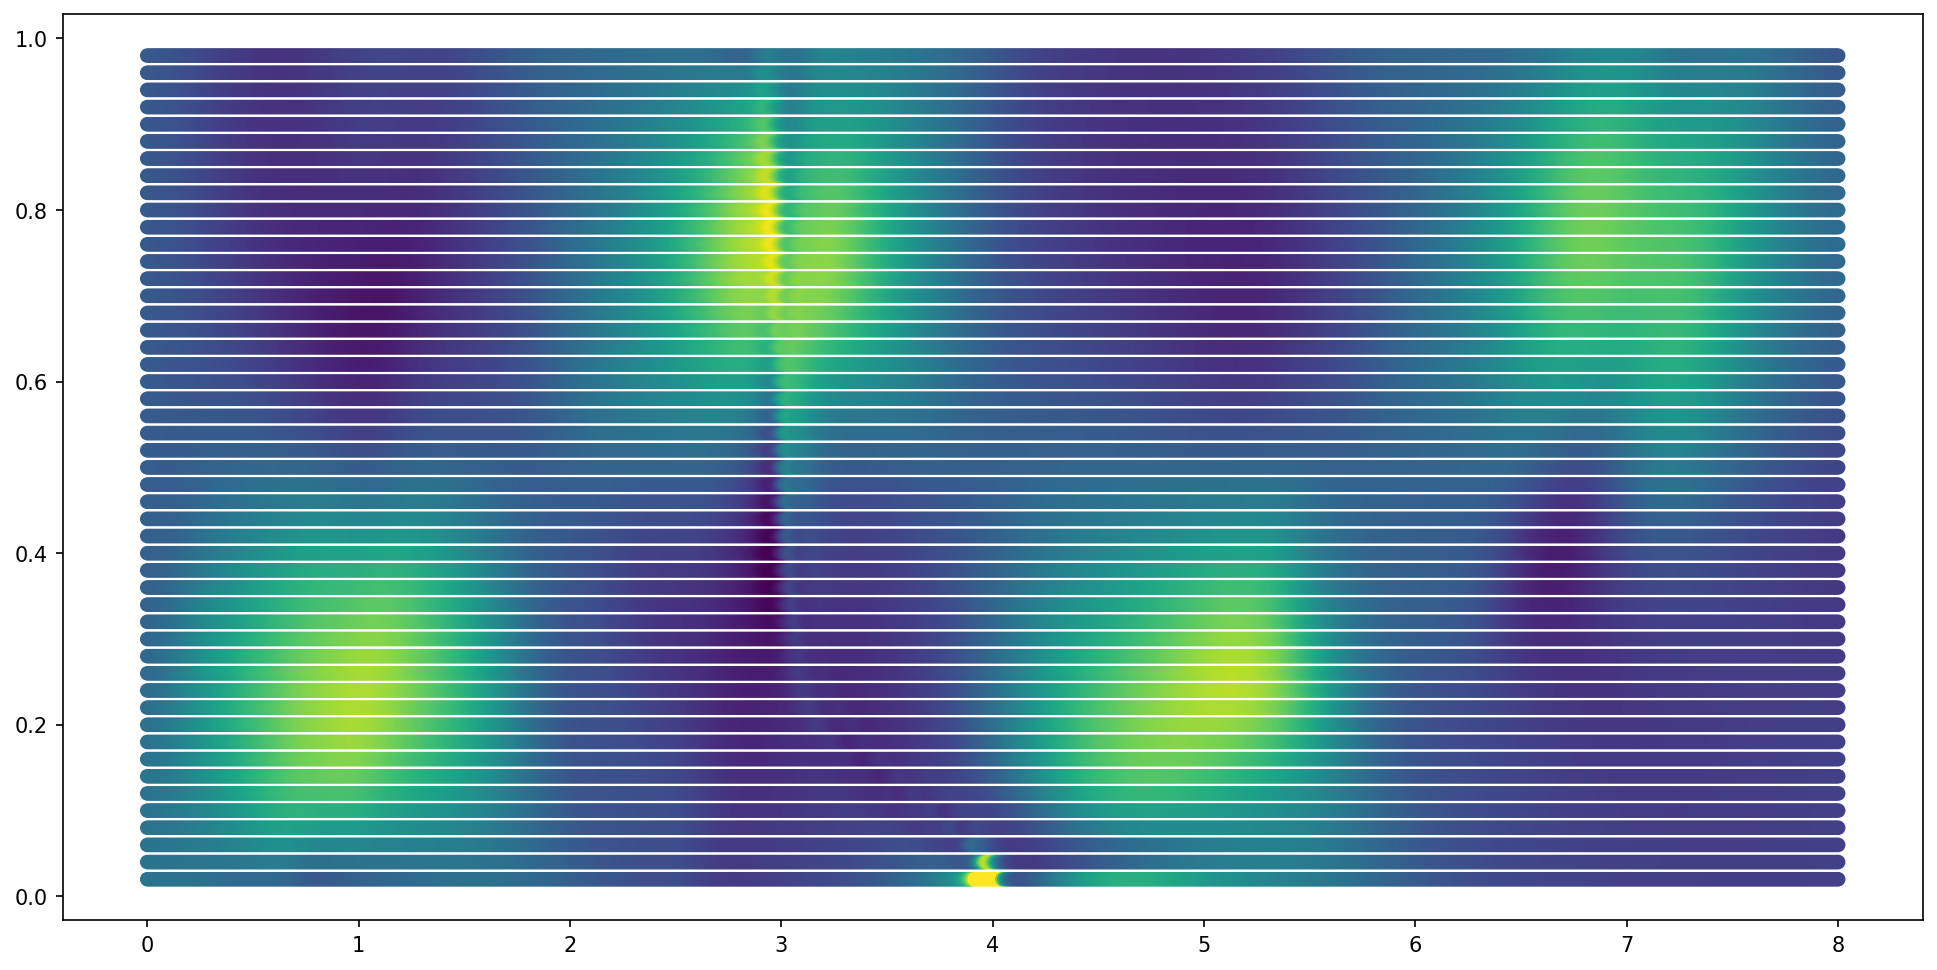

In [152]:
fig, ax = plt.subplots(1,1, figsize = (16,8), dpi=150)
ax.scatter(test_pred['t'], test_pred['x'], c = test_pred['ts'], vmax = 3)
plt.show()
